In [1]:
import glob
from scipy.io import loadmat
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import sklearn
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

In [2]:
df = pd.read_csv('0hp_all_faults.csv')

In [3]:
df.shape

(2782629, 2)

In [4]:
import numpy as np
import pandas as pd
from scipy.signal import stft
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Definicja parametrów
win_len = 784
stride = 300

# Inicjalizacja list dla danych wejściowych (X) i wyjściowych (Y)
X = []
Y = []

# Pętla przez unikalne etykiety w kolumnie 'fault' ramki danych df
for k in df['fault'].unique():
    df_temp_2 = df[df['fault'] == k] # Wybór wierszy odpowiadających danej etykiecie

    for i in np.arange(0, len(df_temp_2) - (win_len), stride):
        temp = df_temp_2.iloc[i:i + win_len, :-1].values
        # Przeprowadzenie STFT na każdej próbce
        f, t, Zxx = stft(temp, nperseg=64) 
        # Przekształcenie amplitudy na wartość bezwzględną
        Zxx = np.abs(Zxx)
        # Dostosowanie kształtu do oczekiwanej postaci
        Zxx = Zxx.reshape((Zxx.shape[1], Zxx.shape[0], 1))  # Zakładam, że chcesz kształt (28, 28, 1)

        X.append(Zxx) # Dodanie danych wejściowych do listy X
        Y.append(df_temp_2.iloc[i + win_len, -1]) # Dodanie etykiety do listy Y
        
# Konwersja list X i Y na tablice numpy        
X = np.array(X)
X=X.reshape((X.shape[0],28,28,1)) # Przekształcenie kształtu danych wejściowych
Y = np.array(Y) 

# Kodowanie etykiet klas za pomocą LabelEncodera i przekształcenie ich na postać one-hot
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

C:\Users\justy\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 64 is greater than input length  = 1, using nperseg = 1
  warnings.warn('nperseg = {0:d} is greater than input length '


In [5]:
X.shape

(9246, 28, 28, 1)

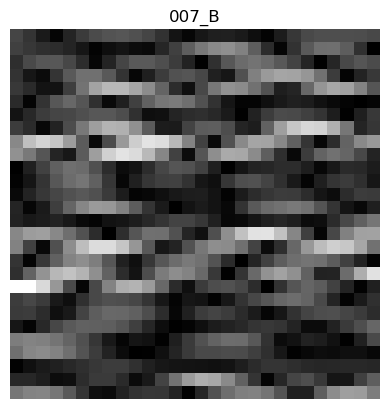

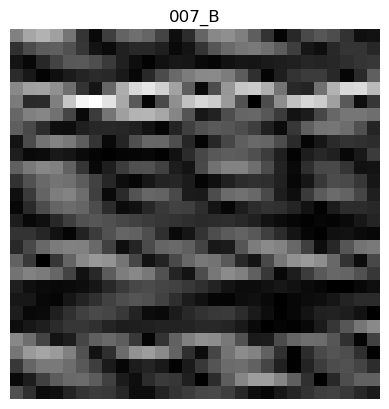

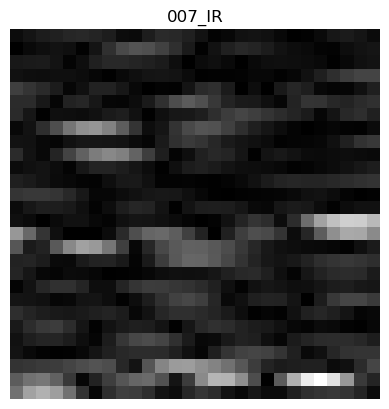

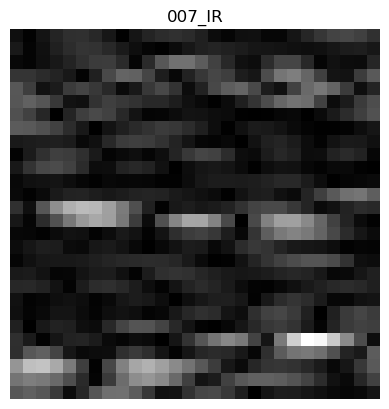

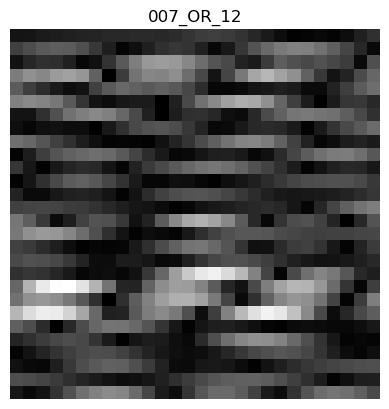

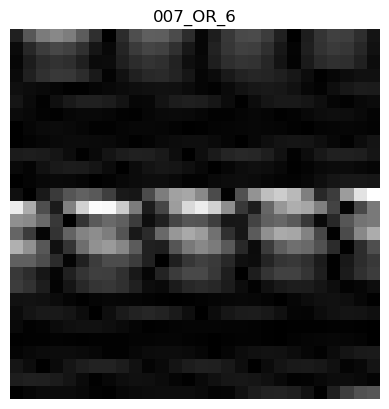

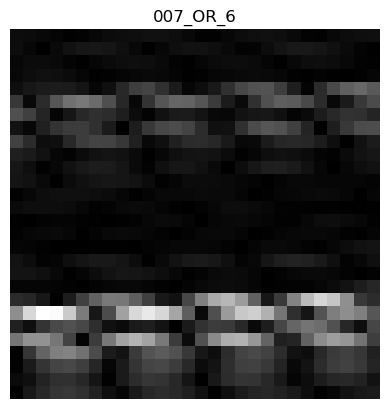

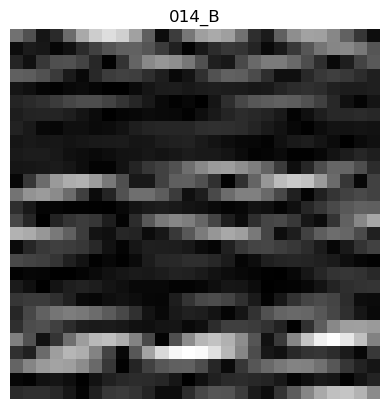

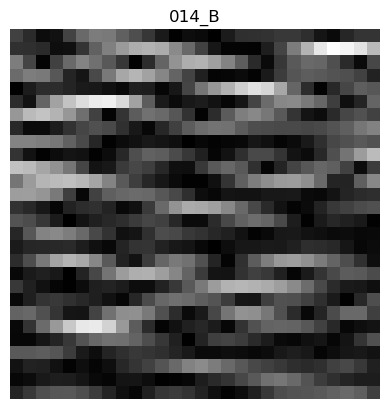

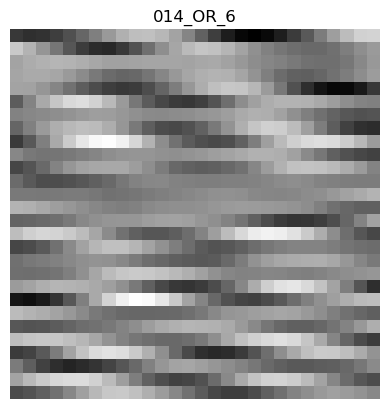

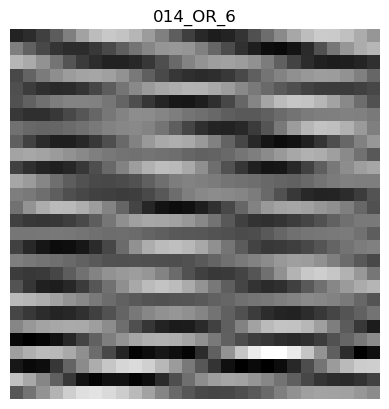

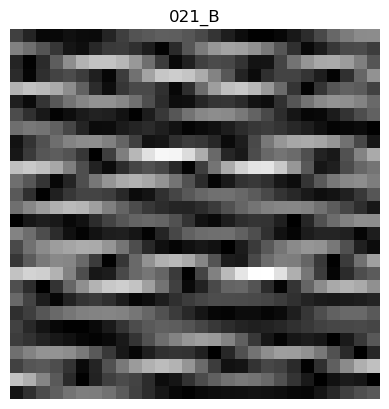

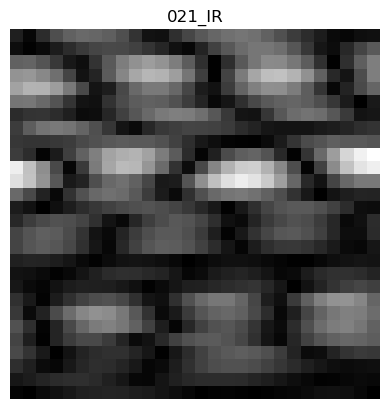

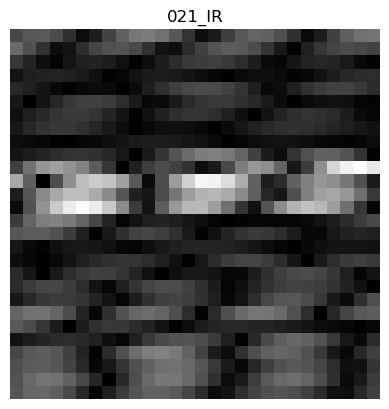

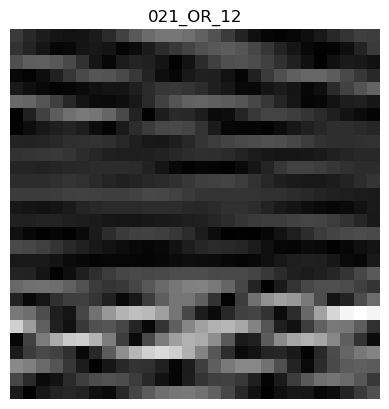

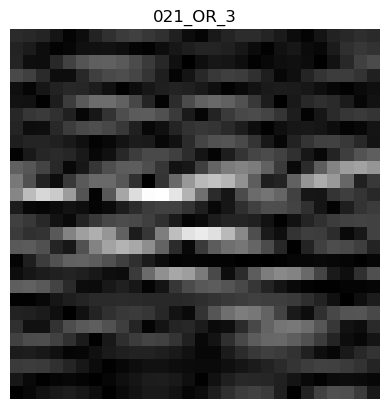

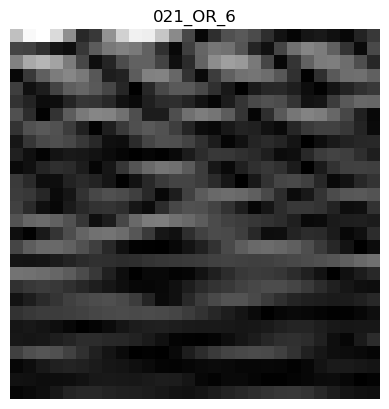

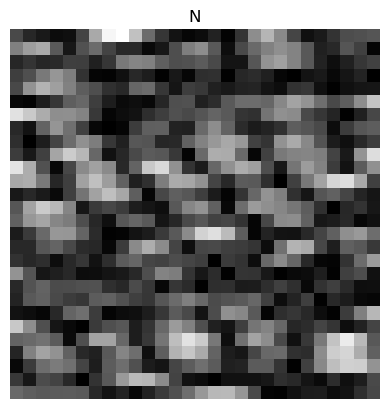

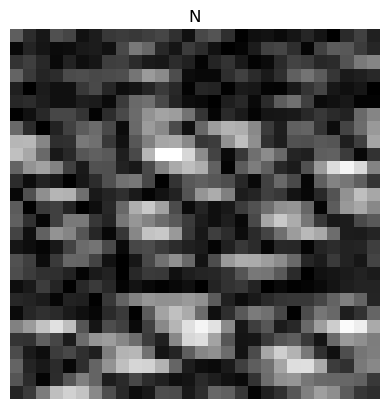

In [6]:
from matplotlib.pyplot import imread

# Pętla przez wybrane indeksy segmentów
# range(0, 9244, 500) oznacza, że pętla przechodzi przez indeksy od 0 do 9244 z krokiem 500
for idx in range(0,9244,500):
    img=X[idx]
    # Wyświetlanie obrazu za pomocą matplotlib
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(Y[idx])
    plt.show()

In [7]:
from sklearn.model_selection import train_test_split
# Podział danych na zbiory treningowy i testowy
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [8]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [9]:
no_classes = len(df['fault'].unique())

cnn_model = Sequential()

cnn_model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1))) # Warstwa konwolucyjna (Convolutional Layer)
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Warstwa sub-sampling (Pooling Layer)
cnn_model.add(Conv2D(32, kernel_size=(5, 5), activation='relu')) # Kolejna warstwa konwolucyjna
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Kolejna warstwa sub-sampling
cnn_model.add(Flatten()) # Warstwa spłaszczająca dane przed wejściem do warstw gęstych
cnn_model.add(Dense(120, activation='relu')) # Warstwa gęsta (Fully Connected Layer)
cnn_model.add(Dense(84, activation='relu')) # Kolejna warstwa gęsta
cnn_model.add(Dense(no_classes, activation='softmax')) # Warstwa wyjściowa
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Kompilacja modelu
cnn_model.summary() # Wyświetlenie struktury modelu

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 64)        1664      
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 32)          51232     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 120)               6

In [10]:
# Definicja wczesnego zatrzymywania
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Trening modelu z wczesnym zatrzymaniem
batch_size = 400
epochs = 80
history = cnn_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping]  # Dodanie wczesnego zatrzymywania do listy callbacks
)

Epoch 1/80
17/17 [==============================] - 6s 241ms/step - loss: 2.3980 - accuracy: 0.1201 - val_loss: 2.1888 - val_accuracy: 0.2707
Epoch 2/80
17/17 [==============================] - 4s 210ms/step - loss: 1.9799 - accuracy: 0.3390 - val_loss: 1.7504 - val_accuracy: 0.4380
Epoch 3/80
17/17 [==============================] - 4s 217ms/step - loss: 1.5881 - accuracy: 0.5470 - val_loss: 1.4197 - val_accuracy: 0.5919
Epoch 4/80
17/17 [==============================] - 4s 212ms/step - loss: 1.2054 - accuracy: 0.6100 - val_loss: 1.1036 - val_accuracy: 0.6226
Epoch 5/80
17/17 [==============================] - 4s 216ms/step - loss: 0.8685 - accuracy: 0.7050 - val_loss: 0.9162 - val_accuracy: 0.7159
Epoch 6/80
17/17 [==============================] - 4s 214ms/step - loss: 0.7243 - accuracy: 0.7525 - val_loss: 0.7362 - val_accuracy: 0.7386
Epoch 7/80
17/17 [==============================] - 4s 220ms/step - loss: 0.6378 - accuracy: 0.7773 - val_loss: 0.6873 - val_accuracy: 0.7531
Epoch 

87/87 [==============================] - 1s 9ms/step


Text(95.72222222222221, 0.5, 'Poprawna klasa')

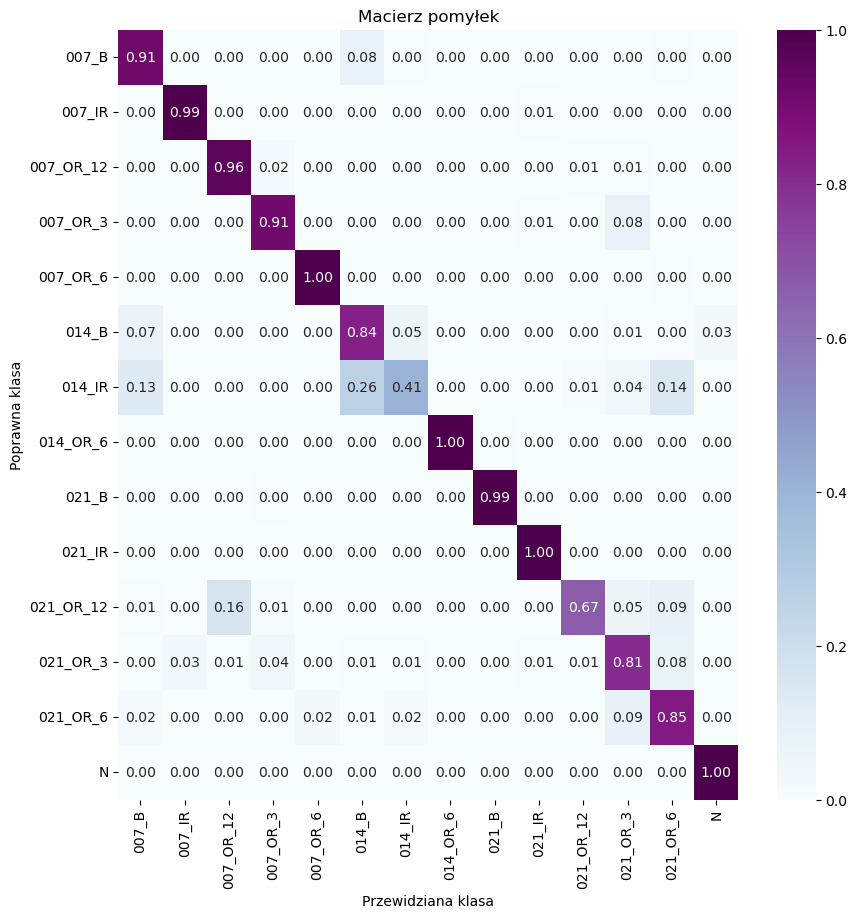

In [11]:
from sklearn.metrics import confusion_matrix

def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1) # Przekształcanie predykcji z formatu one-hot na etykiety klas
    y_pred = encoder.inverse_transform(y_pred) # Inwersja kodowania etykiet na oryginalne wartości
    return y_pred

y_pred=cnn_model.predict(X_test) # Generowanie predykcji modelu

# Przekształcanie wyników predykcji i prawdziwych etykiet
Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)

# Tworzenie macierzy pomyłek
plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True ,xticklabels=encoder.classes_,yticklabels=encoder.classes_, cmap='BuPu', fmt='.2f')
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana klasa')
plt.ylabel('Poprawna klasa')

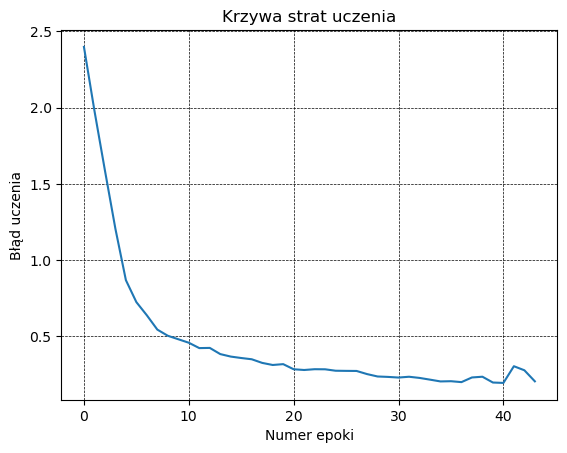

In [12]:
# Wyświetlanie krzywej strat uczenia
plt.title('Krzywa strat uczenia')
plt.xlabel('Numer epoki')
plt.ylabel("Błąd uczenia")
plt.plot(history.history['loss'])
plt.grid(color='k', linestyle='--', linewidth=0.5)

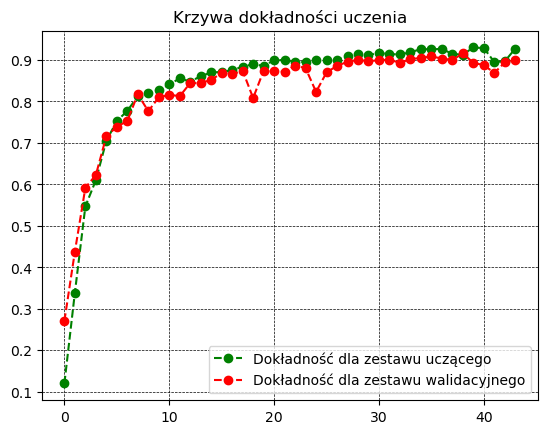

In [13]:
# Wyświetlanie krzywej dokładności uczenia
plt.title('Krzywa dokładności uczenia')
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['Dokładność dla zestawu uczącego','Dokładność dla zestawu walidacyjnego'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

203/203 [==============================] - 2s 8ms/step
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6472 samples in 0.000s...
[t-SNE] Computed neighbors for 6472 samples in 0.550s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6472
[t-SNE] Computed conditional probabilities for sample 2000 / 6472
[t-SNE] Computed conditional probabilities for sample 3000 / 6472
[t-SNE] Computed conditional probabilities for sample 4000 / 6472
[t-SNE] Computed conditional probabilities for sample 5000 / 6472
[t-SNE] Computed conditional probabilities for sample 6000 / 6472
[t-SNE] Computed conditional probabilities for sample 6472 / 6472
[t-SNE] Mean sigma: 1.222597
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.185387
[t-SNE] KL divergence after 300 iterations: 2.139661


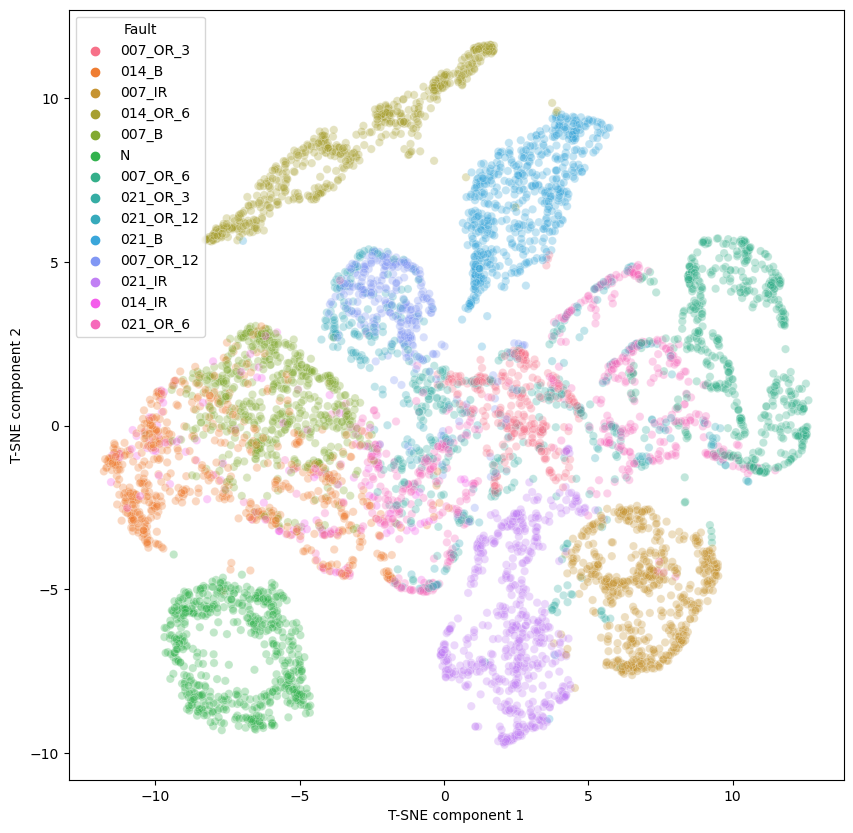

In [14]:
from sklearn.manifold import TSNE

# Tworzenie modelu pomocniczego, który zwraca wyjście z piątej warstwy oryginalnego modelu CNN
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)

# Przepuszczanie danych treningowych przez pomocniczy model, aby uzyskać wyniki z piątej warstwy
y_viz = dummy_cnn.predict(X_train)

# Użycie algorytmu t-SNE do redukcji wymiarowości danych wyjściowych do dwóch wymiarów
X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

# Tworzenie DataFrame z wynikami t-SNE, z kolumnami dla dwóch wymiarów t-SNE
tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

# Przekształcanie etykiet z formatu one-hot do oryginalnych etykiet i dodawanie ich do DataFrame
tSNEdf['Fault']=inv_Transform_result(y_train)


# Wizualizacja wyników t-SNE za pomocą wykresu punktowego
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [15]:
df = pd.read_csv('1hp_all_faults.csv')

In [16]:
import numpy as np
import pandas as pd
from scipy.signal import stft
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Definicja parametrów
win_len = 784
stride = 300

# Inicjalizacja list dla danych wejściowych (X) i wyjściowych (Y)
X = []
Y = []

# Pętla przez unikalne etykiety w kolumnie 'fault' ramki danych df
for k in df['fault'].unique():
    df_temp_2 = df[df['fault'] == k] # Wybór wierszy odpowiadających danej etykiecie

    for i in np.arange(0, len(df_temp_2) - (win_len), stride):
        temp = df_temp_2.iloc[i:i + win_len, :-1].values
        # Przeprowadzenie STFT na każdej próbce
        f, t, Zxx = stft(temp, nperseg=64) 
        # Przekształcenie amplitudy na wartość bezwzględną
        Zxx = np.abs(Zxx)
        # Dostosowanie kształtu do oczekiwanej postaci
        Zxx = Zxx.reshape((Zxx.shape[1], Zxx.shape[0], 1))  # Zakładam, że chcesz kształt (28, 28, 1)

        X.append(Zxx) # Dodanie danych wejściowych do listy X
        Y.append(df_temp_2.iloc[i + win_len, -1]) # Dodanie etykiety do listy Y
        
# Konwersja list X i Y na tablice numpy        
X = np.array(X)
X=X.reshape((X.shape[0],28,28,1)) # Przekształcenie kształtu danych wejściowych
Y = np.array(Y) 

# Kodowanie etykiet klas za pomocą LabelEncodera i przekształcenie ich na postać one-hot
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

C:\Users\justy\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 64 is greater than input length  = 1, using nperseg = 1
  warnings.warn('nperseg = {0:d} is greater than input length '


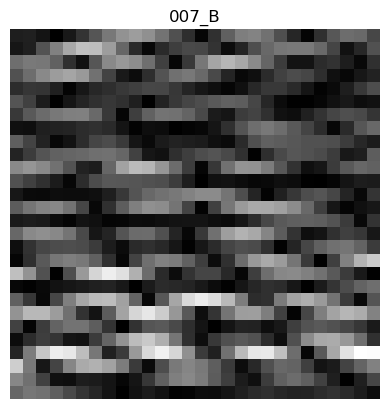

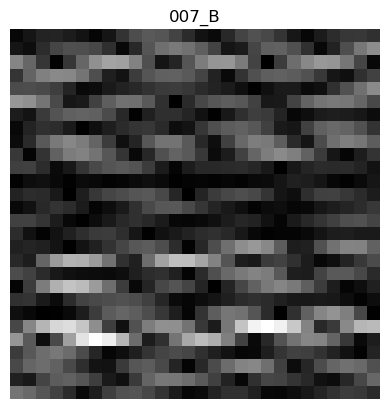

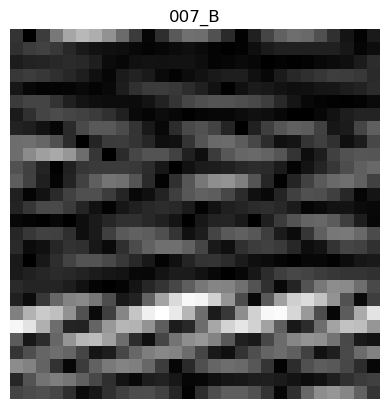

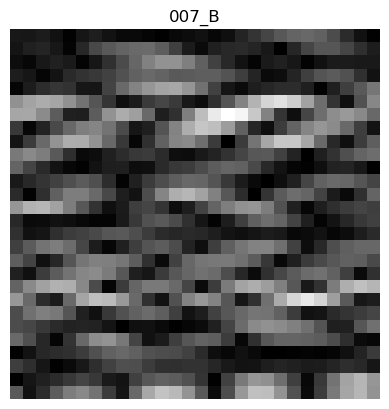

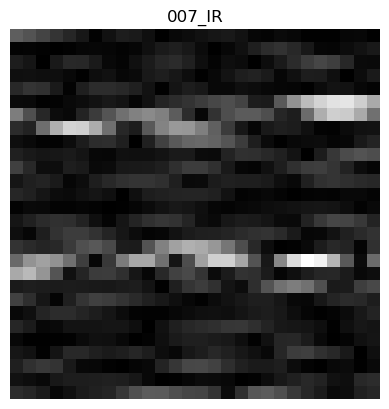

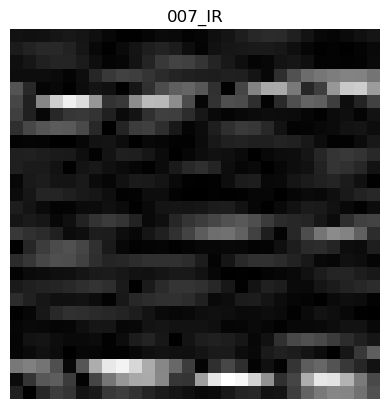

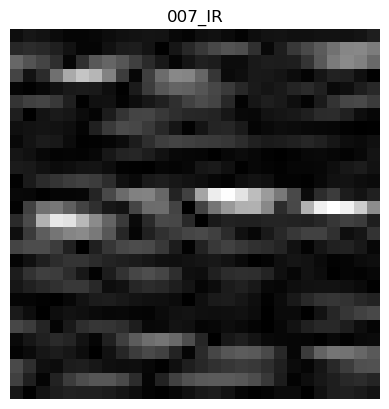

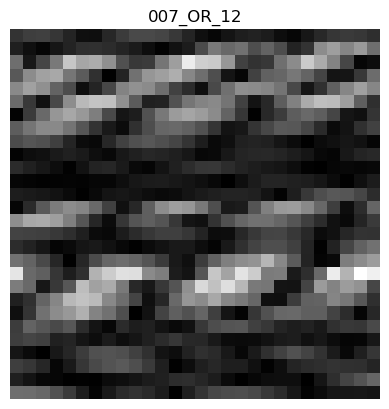

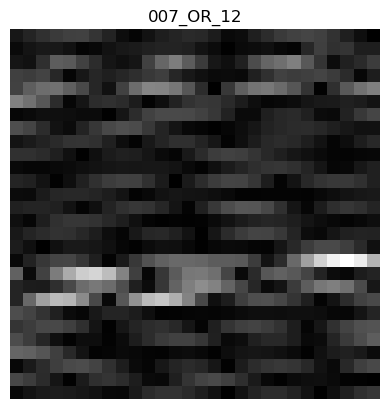

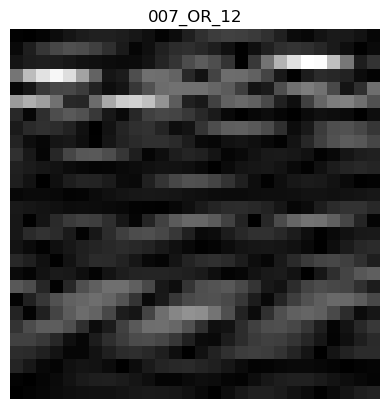

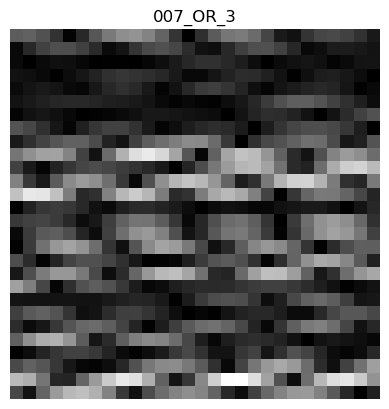

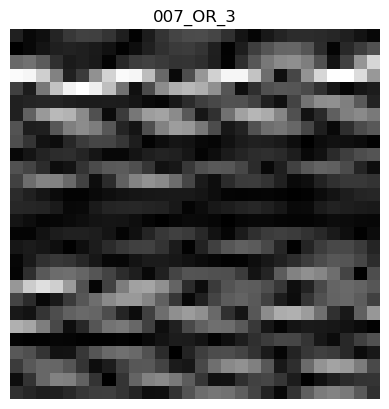

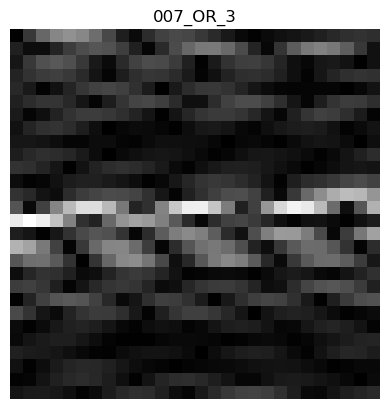

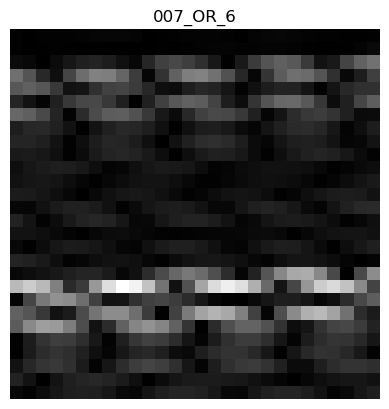

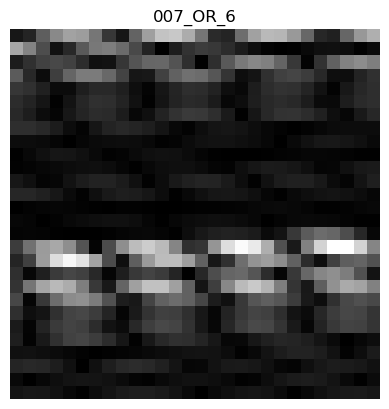

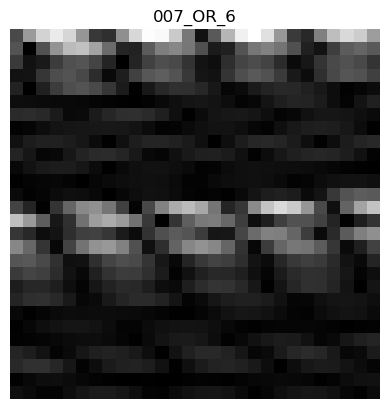

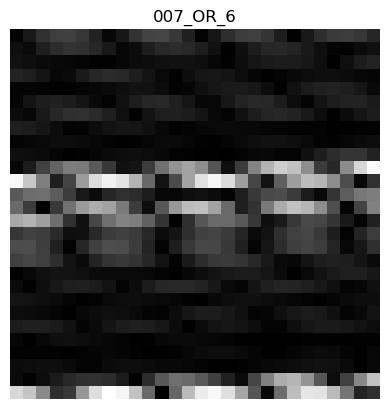

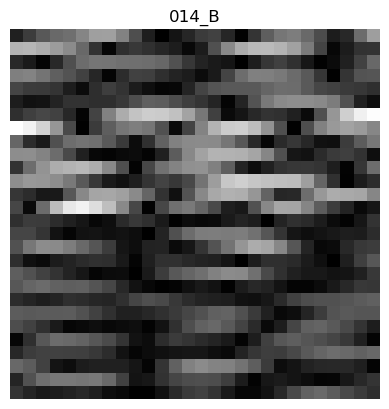

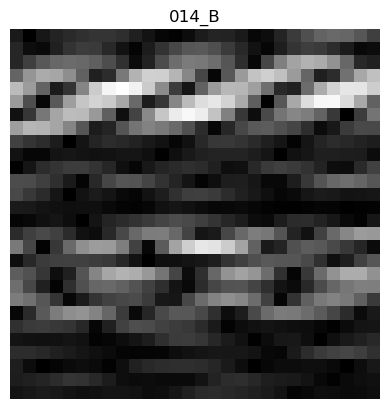

In [17]:
from matplotlib.pyplot import imread

# Pętla przez wybrane indeksy segmentów
# range(0, 9244, 500) oznacza, że pętla przechodzi przez indeksy od 0 do 9244 z krokiem 500
for idx in range(0,9244,500):
    img=X[idx]
    # Wyświetlanie obrazu za pomocą matplotlib
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(Y[idx])
    plt.show()

In [18]:
from sklearn.model_selection import train_test_split
# Podział danych na zbiory treningowy i testowy
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [19]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [20]:
no_classes = len(df['fault'].unique())

cnn_model = Sequential()

cnn_model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1))) # Warstwa konwolucyjna (Convolutional Layer)
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Warstwa sub-sampling (Pooling Layer)
cnn_model.add(Conv2D(32, kernel_size=(5, 5), activation='relu')) # Kolejna warstwa konwolucyjna
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Kolejna warstwa sub-sampling
cnn_model.add(Flatten()) # Warstwa spłaszczająca dane przed wejściem do warstw gęstych
cnn_model.add(Dense(120, activation='relu')) # Warstwa gęsta (Fully Connected Layer)
cnn_model.add(Dense(84, activation='relu')) # Kolejna warstwa gęsta
cnn_model.add(Dense(no_classes, activation='softmax')) # Warstwa wyjściowa
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Kompilacja modelu
cnn_model.summary() # Wyświetlenie struktury modelu

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        1664      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 32)          51232     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 4, 4, 32)          0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 120)              

In [21]:
# Definicja wczesnego zatrzymywania
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Trening modelu z wczesnym zatrzymaniem
batch_size = 400
epochs = 80
history = cnn_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping]  # Dodanie wczesnego zatrzymywania do listy callbacks
)

Epoch 1/80
40/40 [==============================] - 12s 261ms/step - loss: 2.2966 - accuracy: 0.1765 - val_loss: 1.8524 - val_accuracy: 0.4148
Epoch 2/80
40/40 [==============================] - 10s 259ms/step - loss: 1.4061 - accuracy: 0.5236 - val_loss: 1.4108 - val_accuracy: 0.5379
Epoch 3/80
40/40 [==============================] - 10s 249ms/step - loss: 0.9886 - accuracy: 0.6421 - val_loss: 0.8621 - val_accuracy: 0.6821
Epoch 4/80
40/40 [==============================] - 10s 246ms/step - loss: 0.8018 - accuracy: 0.6963 - val_loss: 0.7748 - val_accuracy: 0.6964
Epoch 5/80
40/40 [==============================] - 10s 254ms/step - loss: 0.7453 - accuracy: 0.7142 - val_loss: 0.7136 - val_accuracy: 0.7256
Epoch 6/80
40/40 [==============================] - 10s 244ms/step - loss: 0.6876 - accuracy: 0.7326 - val_loss: 0.8987 - val_accuracy: 0.6543
Epoch 7/80
40/40 [==============================] - 10s 249ms/step - loss: 0.6847 - accuracy: 0.7380 - val_loss: 0.7737 - val_accuracy: 0.6952

210/210 [==============================] - 2s 11ms/step


Text(95.72222222222221, 0.5, 'Poprawna klasa')

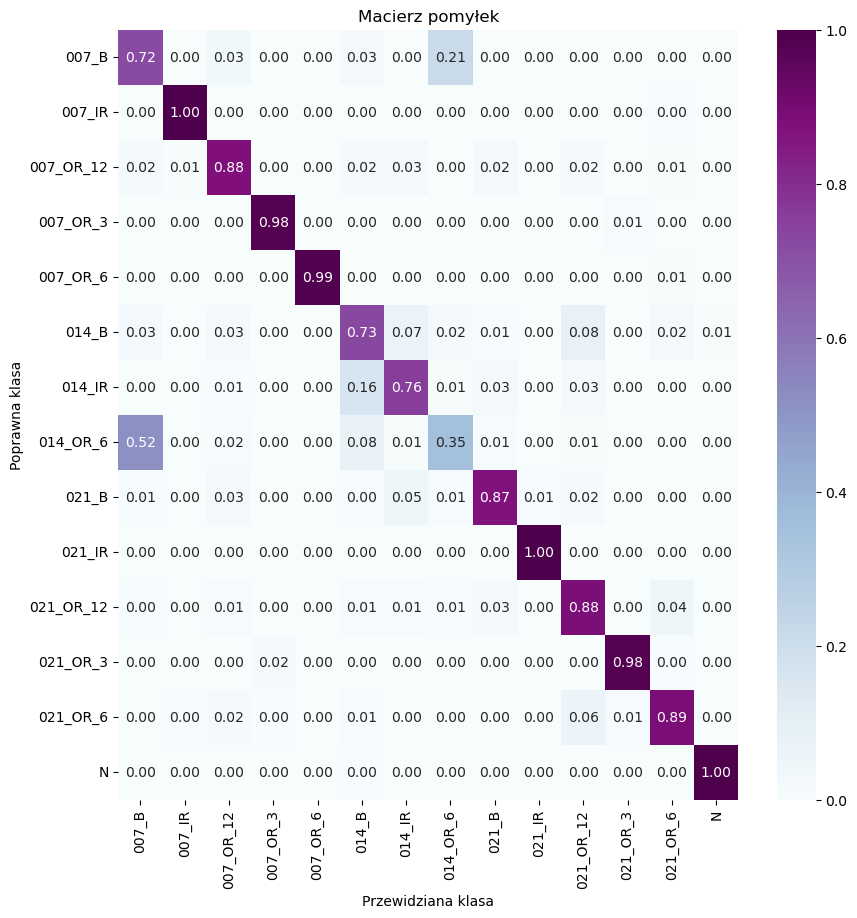

In [22]:
from sklearn.metrics import confusion_matrix

def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1) # Przekształcanie predykcji z formatu one-hot na etykiety klas
    y_pred = encoder.inverse_transform(y_pred) # Inwersja kodowania etykiet na oryginalne wartości
    return y_pred

y_pred=cnn_model.predict(X_test) # Generowanie predykcji modelu

# Przekształcanie wyników predykcji i prawdziwych etykiet
Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)

# Tworzenie macierzy pomyłek
plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True ,xticklabels=encoder.classes_,yticklabels=encoder.classes_, cmap='BuPu', fmt='.2f')
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana klasa')
plt.ylabel('Poprawna klasa')

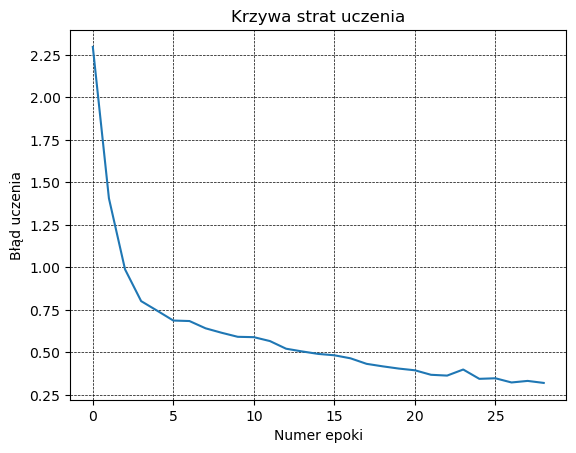

In [23]:
# Wyświetlanie krzywej strat uczenia
plt.title('Krzywa strat uczenia')
plt.xlabel('Numer epoki')
plt.ylabel("Błąd uczenia")
plt.plot(history.history['loss'])
plt.grid(color='k', linestyle='--', linewidth=0.5)

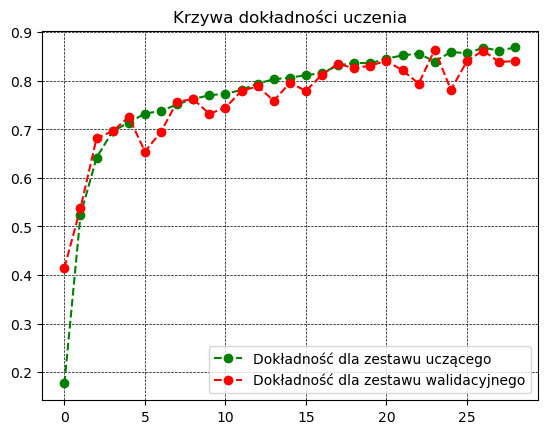

In [24]:
# Wyświetlanie krzywej dokładności uczenia
plt.title('Krzywa dokładności uczenia')
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['Dokładność dla zestawu uczącego','Dokładność dla zestawu walidacyjnego'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

489/489 [==============================] - 5s 10ms/step
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15617 samples in 0.001s...
[t-SNE] Computed neighbors for 15617 samples in 1.997s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15617
[t-SNE] Computed conditional probabilities for sample 2000 / 15617
[t-SNE] Computed conditional probabilities for sample 3000 / 15617
[t-SNE] Computed conditional probabilities for sample 4000 / 15617
[t-SNE] Computed conditional probabilities for sample 5000 / 15617
[t-SNE] Computed conditional probabilities for sample 6000 / 15617
[t-SNE] Computed conditional probabilities for sample 7000 / 15617
[t-SNE] Computed conditional probabilities for sample 8000 / 15617
[t-SNE] Computed conditional probabilities for sample 9000 / 15617
[t-SNE] Computed conditional probabilities for sample 10000 / 15617
[t-SNE] Computed conditional probabilities for sample 11000 / 15617
[t-SNE] Computed conditional probabilities for sample 12000 /

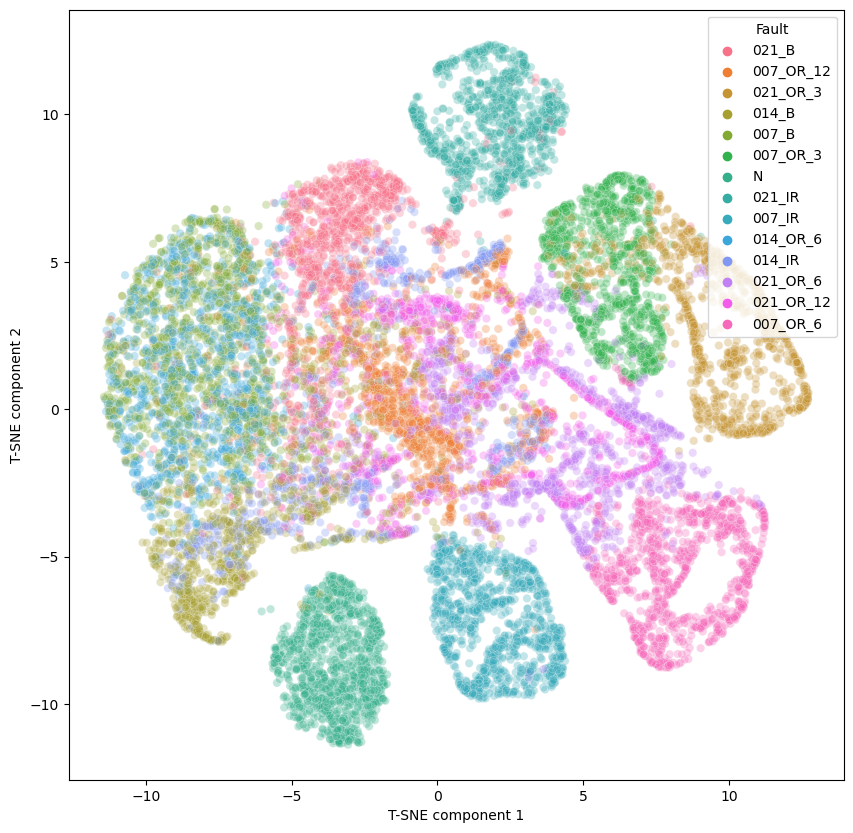

In [25]:
from sklearn.manifold import TSNE

# Tworzenie modelu pomocniczego, który zwraca wyjście z piątej warstwy oryginalnego modelu CNN
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)

# Przepuszczanie danych treningowych przez pomocniczy model, aby uzyskać wyniki z piątej warstwy
y_viz = dummy_cnn.predict(X_train)

# Użycie algorytmu t-SNE do redukcji wymiarowości danych wyjściowych do dwóch wymiarów
X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

# Tworzenie DataFrame z wynikami t-SNE, z kolumnami dla dwóch wymiarów t-SNE
tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

# Przekształcanie etykiet z formatu one-hot do oryginalnych etykiet i dodawanie ich do DataFrame
tSNEdf['Fault']=inv_Transform_result(y_train)


# Wizualizacja wyników t-SNE za pomocą wykresu punktowego
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [26]:
df = pd.read_csv('2hp_all_faults.csv')

In [27]:
import numpy as np
import pandas as pd
from scipy.signal import stft
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Definicja parametrów
win_len = 784
stride = 300

# Inicjalizacja list dla danych wejściowych (X) i wyjściowych (Y)
X = []
Y = []

# Pętla przez unikalne etykiety w kolumnie 'fault' ramki danych df
for k in df['fault'].unique():
    df_temp_2 = df[df['fault'] == k] # Wybór wierszy odpowiadających danej etykiecie

    for i in np.arange(0, len(df_temp_2) - (win_len), stride):
        temp = df_temp_2.iloc[i:i + win_len, :-1].values
        # Przeprowadzenie STFT na każdej próbce
        f, t, Zxx = stft(temp, nperseg=64) 
        # Przekształcenie amplitudy na wartość bezwzględną
        Zxx = np.abs(Zxx)
        # Dostosowanie kształtu do oczekiwanej postaci
        Zxx = Zxx.reshape((Zxx.shape[1], Zxx.shape[0], 1))  # Zakładam, że chcesz kształt (28, 28, 1)

        X.append(Zxx) # Dodanie danych wejściowych do listy X
        Y.append(df_temp_2.iloc[i + win_len, -1]) # Dodanie etykiety do listy Y
        
# Konwersja list X i Y na tablice numpy        
X = np.array(X)
X=X.reshape((X.shape[0],28,28,1)) # Przekształcenie kształtu danych wejściowych
Y = np.array(Y) 

# Kodowanie etykiet klas za pomocą LabelEncodera i przekształcenie ich na postać one-hot
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

C:\Users\justy\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 64 is greater than input length  = 1, using nperseg = 1
  warnings.warn('nperseg = {0:d} is greater than input length '


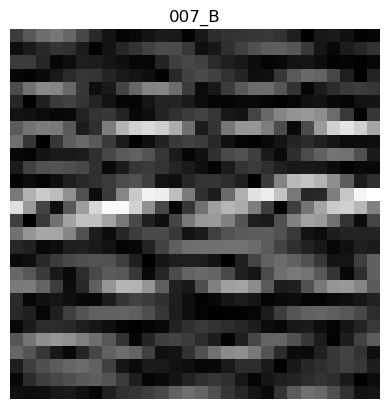

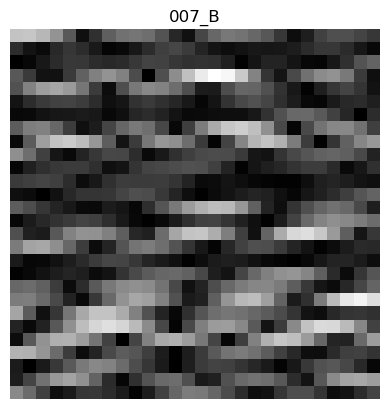

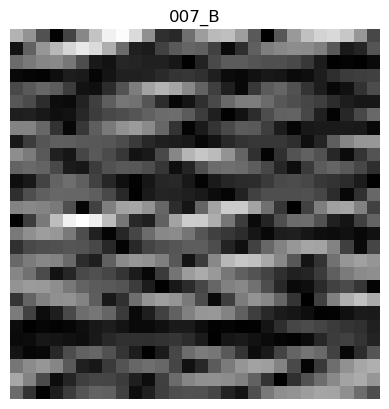

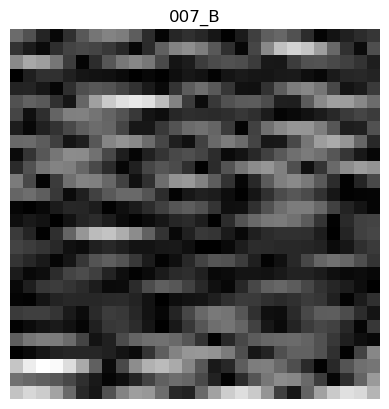

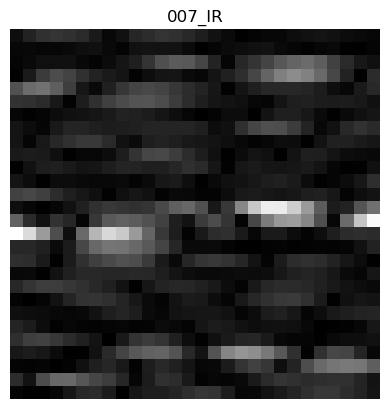

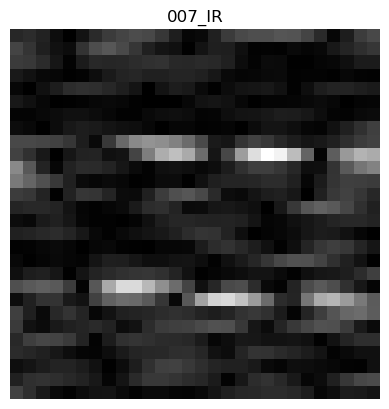

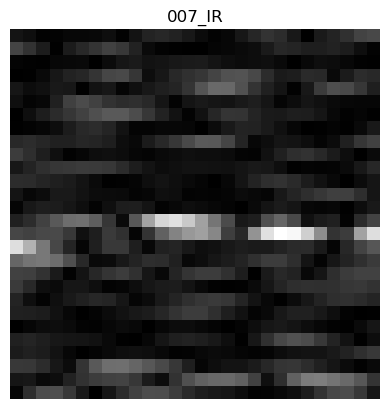

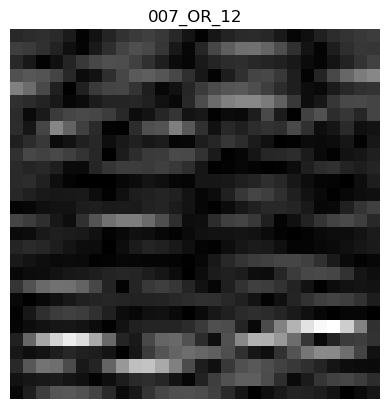

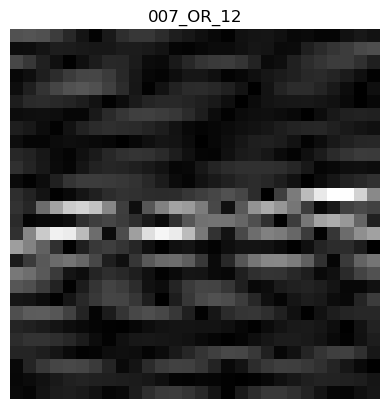

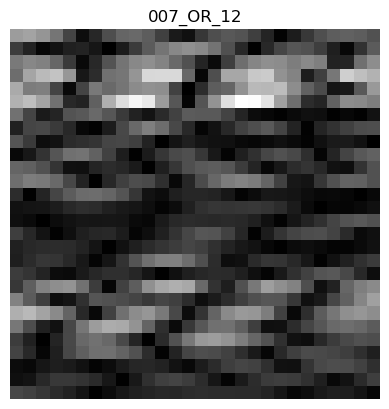

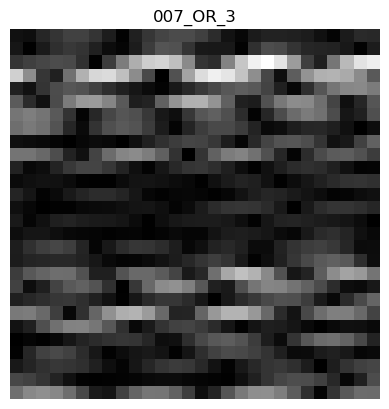

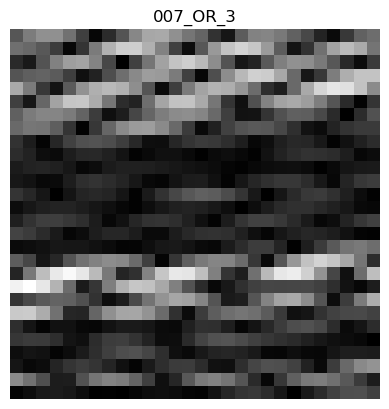

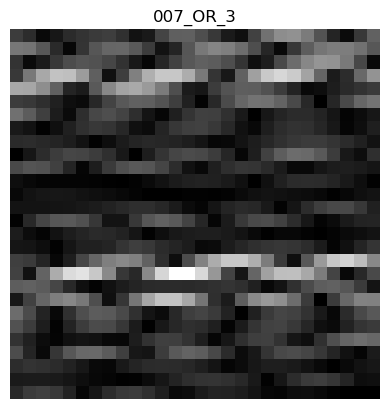

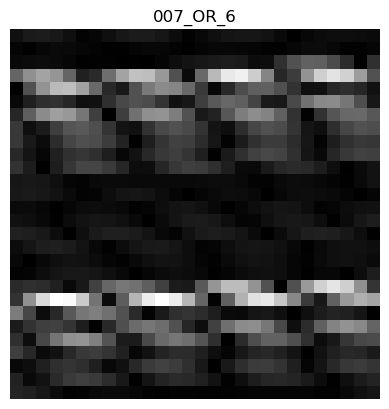

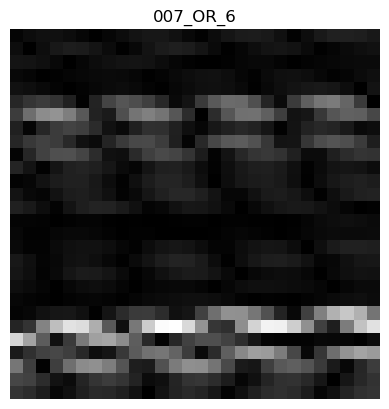

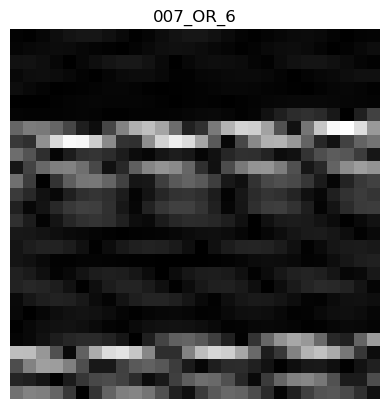

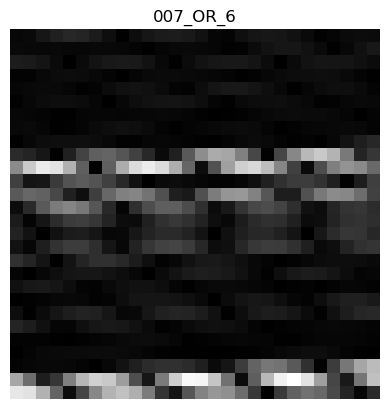

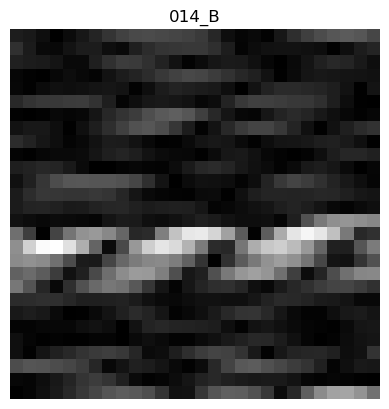

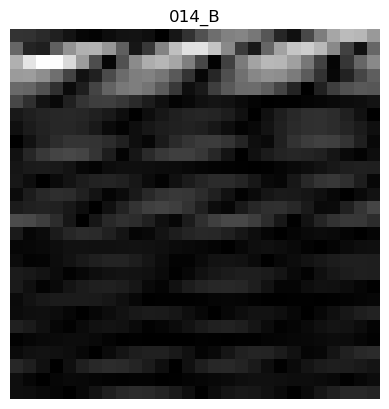

In [28]:
from matplotlib.pyplot import imread

# Pętla przez wybrane indeksy segmentów
# range(0, 9244, 500) oznacza, że pętla przechodzi przez indeksy od 0 do 9244 z krokiem 500
for idx in range(0,9244,500):
    img=X[idx]
    # Wyświetlanie obrazu za pomocą matplotlib
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(Y[idx])
    plt.show()

In [29]:
from sklearn.model_selection import train_test_split
# Podział danych na zbiory treningowy i testowy
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [30]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
no_classes = len(df['fault'].unique())

cnn_model = Sequential()

cnn_model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1))) # Warstwa konwolucyjna (Convolutional Layer)
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Warstwa sub-sampling (Pooling Layer)
cnn_model.add(Conv2D(32, kernel_size=(5, 5), activation='relu')) # Kolejna warstwa konwolucyjna
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Kolejna warstwa sub-sampling
cnn_model.add(Flatten()) # Warstwa spłaszczająca dane przed wejściem do warstw gęstych
cnn_model.add(Dense(120, activation='relu')) # Warstwa gęsta (Fully Connected Layer)
cnn_model.add(Dense(84, activation='relu')) # Kolejna warstwa gęsta
cnn_model.add(Dense(no_classes, activation='softmax')) # Warstwa wyjściowa
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Kompilacja modelu
cnn_model.summary() # Wyświetlenie struktury modelu

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        1664      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 32)          51232     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 4, 32)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 120)              

In [32]:
# Definicja wczesnego zatrzymywania
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Trening modelu z wczesnym zatrzymaniem
batch_size = 400
epochs = 80
history = cnn_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping]  # Dodanie wczesnego zatrzymywania do listy callbacks
)

Epoch 1/80
40/40 [==============================] - 11s 251ms/step - loss: 2.3120 - accuracy: 0.1698 - val_loss: 1.9489 - val_accuracy: 0.3137
Epoch 2/80
40/40 [==============================] - 10s 248ms/step - loss: 1.4706 - accuracy: 0.4950 - val_loss: 1.0463 - val_accuracy: 0.6135
Epoch 3/80
40/40 [==============================] - 10s 254ms/step - loss: 0.9426 - accuracy: 0.6508 - val_loss: 0.8458 - val_accuracy: 0.6777
Epoch 4/80
40/40 [==============================] - 10s 257ms/step - loss: 0.8145 - accuracy: 0.6963 - val_loss: 0.7291 - val_accuracy: 0.7252
Epoch 5/80
40/40 [==============================] - 11s 265ms/step - loss: 0.7298 - accuracy: 0.7214 - val_loss: 0.6854 - val_accuracy: 0.7316
Epoch 6/80
40/40 [==============================] - 10s 251ms/step - loss: 0.6778 - accuracy: 0.7406 - val_loss: 0.7009 - val_accuracy: 0.7272
Epoch 7/80
40/40 [==============================] - 10s 262ms/step - loss: 0.6380 - accuracy: 0.7560 - val_loss: 0.6097 - val_accuracy: 0.7616

Epoch 58/80
40/40 [==============================] - 11s 271ms/step - loss: 0.1973 - accuracy: 0.9131 - val_loss: 0.2930 - val_accuracy: 0.8753
Epoch 59/80
40/40 [==============================] - 11s 273ms/step - loss: 0.1923 - accuracy: 0.9147 - val_loss: 0.2646 - val_accuracy: 0.8829
Epoch 60/80
40/40 [==============================] - 11s 267ms/step - loss: 0.1847 - accuracy: 0.9213 - val_loss: 0.2800 - val_accuracy: 0.8835
Epoch 61/80
40/40 [==============================] - 11s 264ms/step - loss: 0.1737 - accuracy: 0.9266 - val_loss: 0.2676 - val_accuracy: 0.8832
Epoch 62/80
40/40 [==============================] - 11s 271ms/step - loss: 0.1786 - accuracy: 0.9250 - val_loss: 0.2922 - val_accuracy: 0.8785
Epoch 63/80
40/40 [==============================] - 11s 275ms/step - loss: 0.1754 - accuracy: 0.9267 - val_loss: 0.2780 - val_accuracy: 0.8851
Epoch 64/80
40/40 [==============================] - 11s 274ms/step - loss: 0.1719 - accuracy: 0.9273 - val_loss: 0.2627 - val_accuracy:

213/213 [==============================] - 2s 9ms/step


Text(95.72222222222221, 0.5, 'Poprawna klasa')

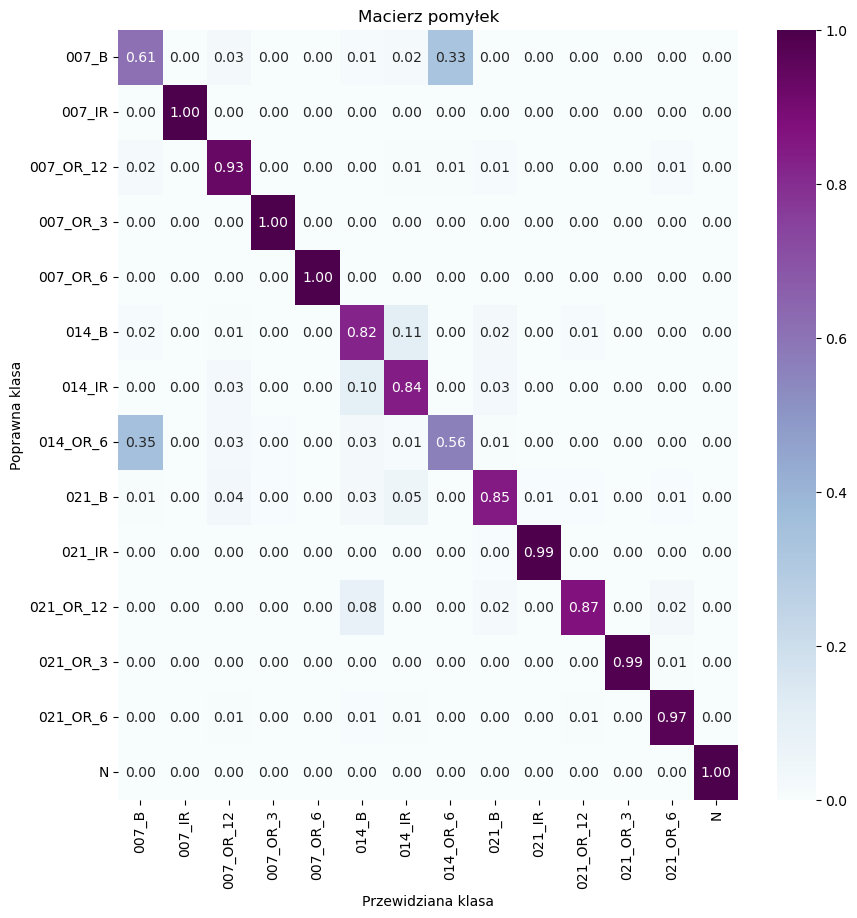

In [33]:
from sklearn.metrics import confusion_matrix

def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1) # Przekształcanie predykcji z formatu one-hot na etykiety klas
    y_pred = encoder.inverse_transform(y_pred) # Inwersja kodowania etykiet na oryginalne wartości
    return y_pred

y_pred=cnn_model.predict(X_test) # Generowanie predykcji modelu

# Przekształcanie wyników predykcji i prawdziwych etykiet
Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)

# Tworzenie macierzy pomyłek
plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True ,xticklabels=encoder.classes_,yticklabels=encoder.classes_, cmap='BuPu', fmt='.2f')
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana klasa')
plt.ylabel('Poprawna klasa')

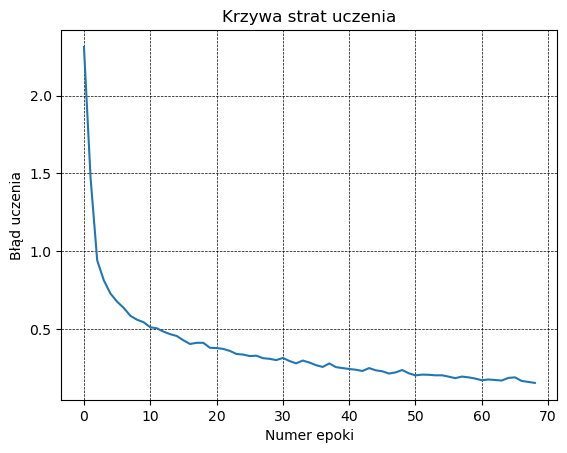

In [34]:
# Wyświetlanie krzywej strat uczenia
plt.title('Krzywa strat uczenia')
plt.xlabel('Numer epoki')
plt.ylabel("Błąd uczenia")
plt.plot(history.history['loss'])
plt.grid(color='k', linestyle='--', linewidth=0.5)

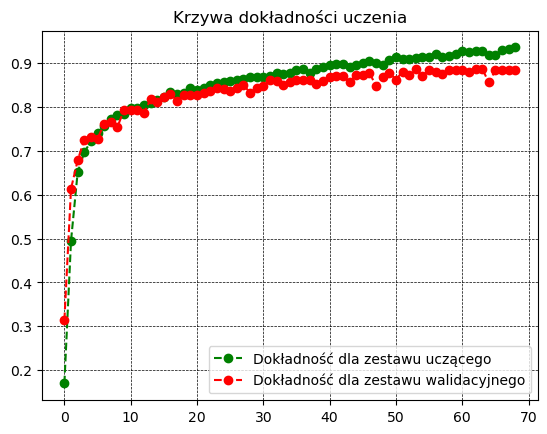

In [35]:
# Wyświetlanie dokładności uczenia
plt.title('Krzywa dokładności uczenia')
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['Dokładność dla zestawu uczącego','Dokładność dla zestawu walidacyjnego'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

497/497 [==============================] - 5s 10ms/step
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15884 samples in 0.000s...
[t-SNE] Computed neighbors for 15884 samples in 1.760s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15884
[t-SNE] Computed conditional probabilities for sample 2000 / 15884
[t-SNE] Computed conditional probabilities for sample 3000 / 15884
[t-SNE] Computed conditional probabilities for sample 4000 / 15884
[t-SNE] Computed conditional probabilities for sample 5000 / 15884
[t-SNE] Computed conditional probabilities for sample 6000 / 15884
[t-SNE] Computed conditional probabilities for sample 7000 / 15884
[t-SNE] Computed conditional probabilities for sample 8000 / 15884
[t-SNE] Computed conditional probabilities for sample 9000 / 15884
[t-SNE] Computed conditional probabilities for sample 10000 / 15884
[t-SNE] Computed conditional probabilities for sample 11000 / 15884
[t-SNE] Computed conditional probabilities for sample 12000 /

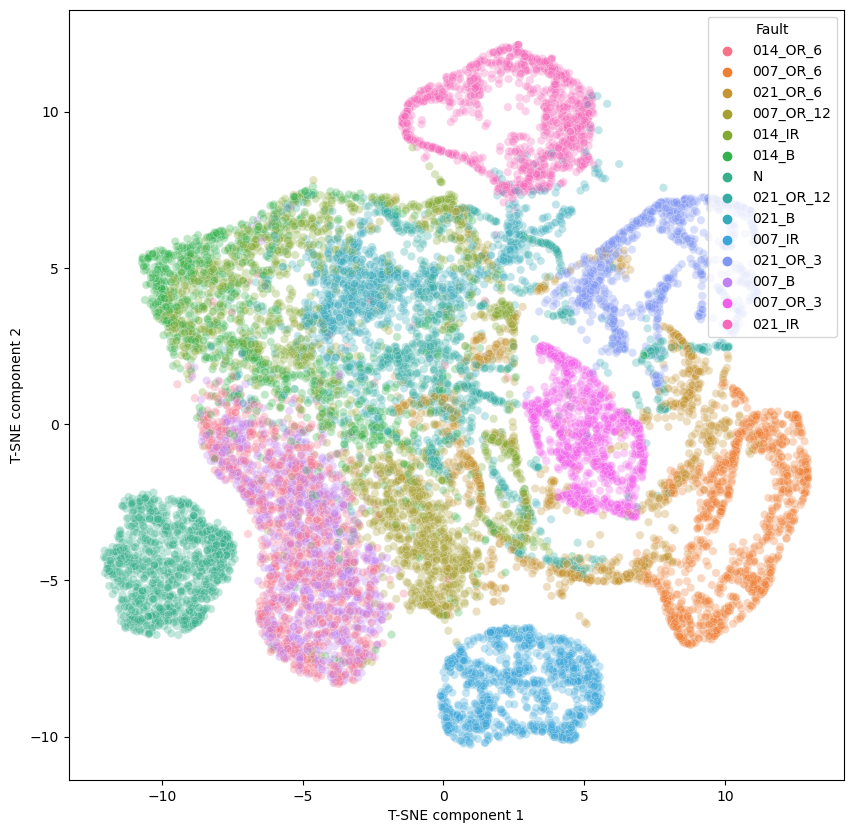

In [36]:
from sklearn.manifold import TSNE

# Tworzenie modelu pomocniczego, który zwraca wyjście z piątej warstwy oryginalnego modelu CNN
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)

# Przepuszczanie danych treningowych przez pomocniczy model, aby uzyskać wyniki z piątej warstwy
y_viz = dummy_cnn.predict(X_train)

# Użycie algorytmu t-SNE do redukcji wymiarowości danych wyjściowych do dwóch wymiarów
X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

# Tworzenie DataFrame z wynikami t-SNE, z kolumnami dla dwóch wymiarów t-SNE
tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

# Przekształcanie etykiet z formatu one-hot do oryginalnych etykiet i dodawanie ich do DataFrame
tSNEdf['Fault']=inv_Transform_result(y_train)


# Wizualizacja wyników t-SNE za pomocą wykresu punktowego
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [37]:
df = pd.read_csv('3hp_all_faults.csv')

In [38]:
import numpy as np
import pandas as pd
from scipy.signal import stft
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Definicja parametrów
win_len = 784
stride = 300

# Inicjalizacja list dla danych wejściowych (X) i wyjściowych (Y)
X = []
Y = []

# Pętla przez unikalne etykiety w kolumnie 'fault' ramki danych df
for k in df['fault'].unique():
    df_temp_2 = df[df['fault'] == k] # Wybór wierszy odpowiadających danej etykiecie

    for i in np.arange(0, len(df_temp_2) - (win_len), stride):
        temp = df_temp_2.iloc[i:i + win_len, :-1].values
        # Przeprowadzenie STFT na każdej próbce
        f, t, Zxx = stft(temp, nperseg=64) 
        # Przekształcenie amplitudy na wartość bezwzględną
        Zxx = np.abs(Zxx)
        # Dostosowanie kształtu do oczekiwanej postaci
        Zxx = Zxx.reshape((Zxx.shape[1], Zxx.shape[0], 1))  # Zakładam, że chcesz kształt (28, 28, 1)

        X.append(Zxx) # Dodanie danych wejściowych do listy X
        Y.append(df_temp_2.iloc[i + win_len, -1]) # Dodanie etykiety do listy Y
        
# Konwersja list X i Y na tablice numpy        
X = np.array(X)
X=X.reshape((X.shape[0],28,28,1)) # Przekształcenie kształtu danych wejściowych
Y = np.array(Y) 

# Kodowanie etykiet klas za pomocą LabelEncodera i przekształcenie ich na postać one-hot
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

C:\Users\justy\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:2014: UserWarning: nperseg = 64 is greater than input length  = 1, using nperseg = 1
  warnings.warn('nperseg = {0:d} is greater than input length '


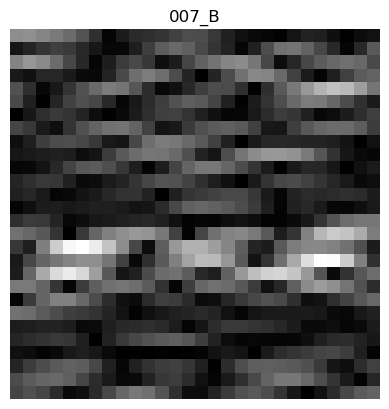

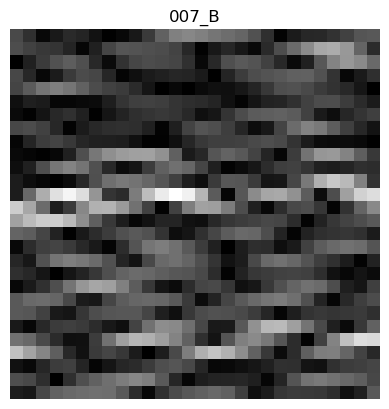

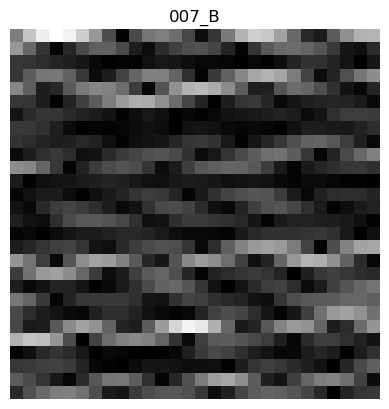

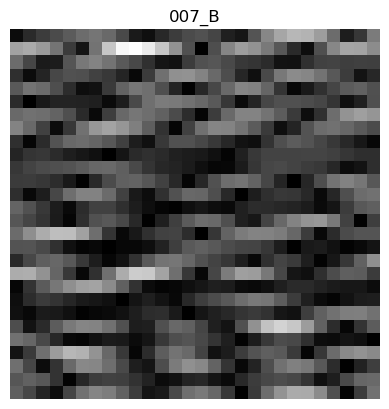

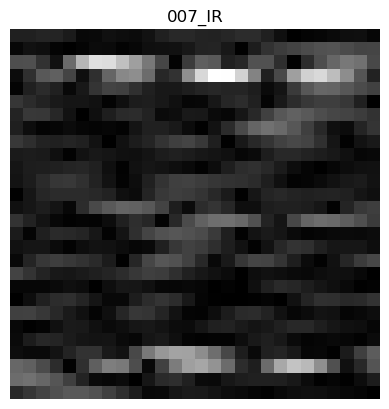

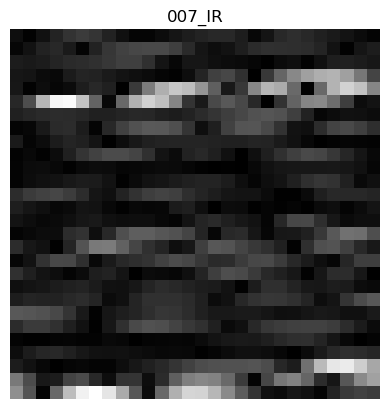

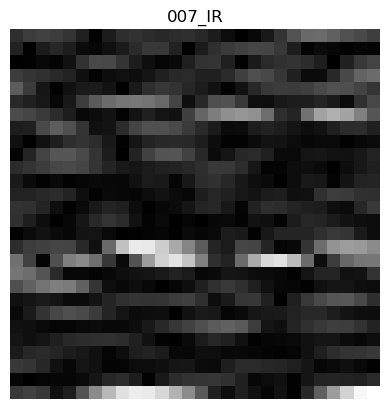

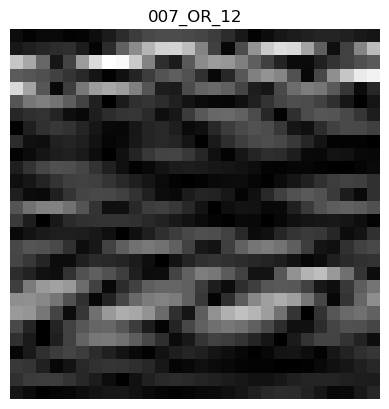

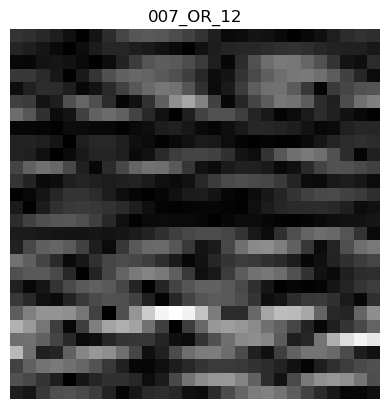

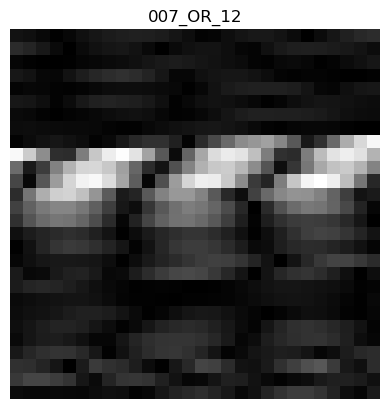

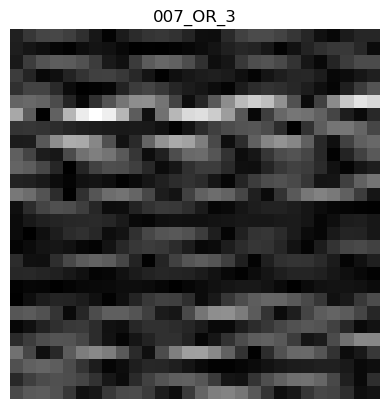

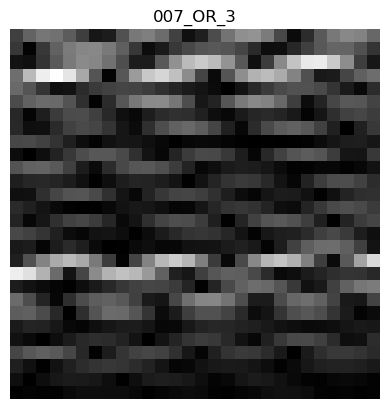

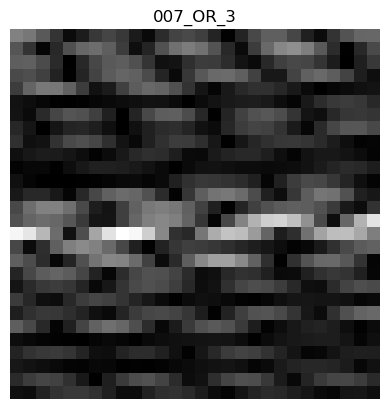

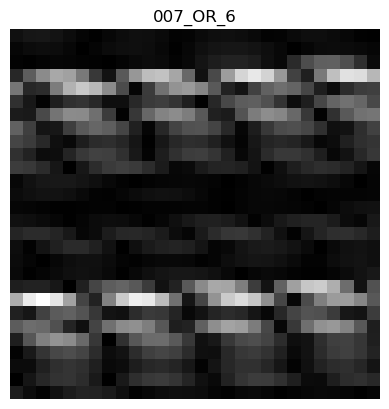

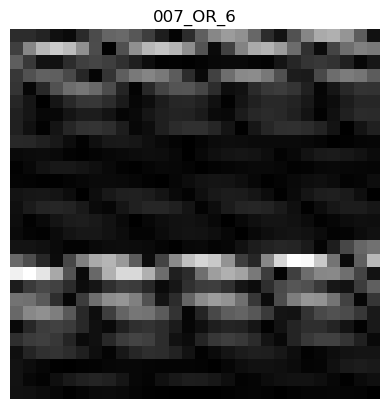

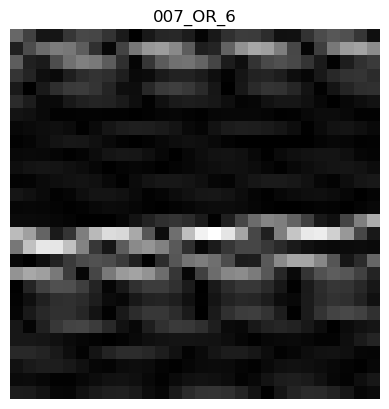

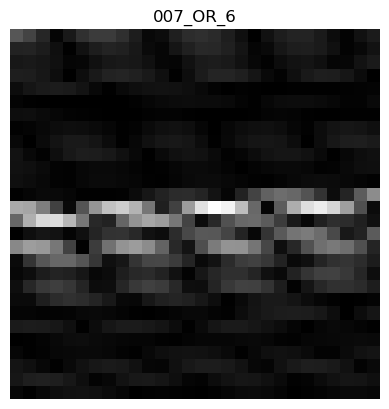

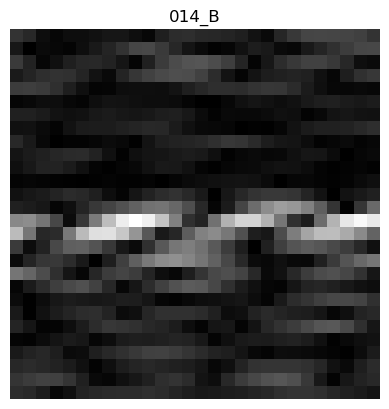

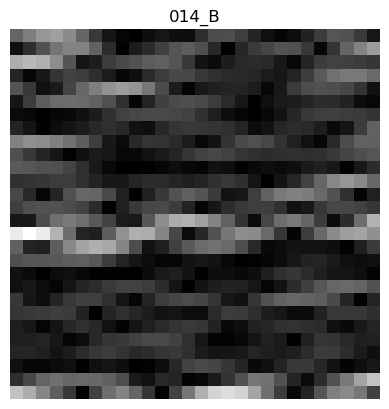

In [39]:
from matplotlib.pyplot import imread

# Pętla przez wybrane indeksy segmentów
# range(0, 9244, 500) oznacza, że pętla przechodzi przez indeksy od 0 do 9244 z krokiem 500
for idx in range(0,9244,500):
    img=X[idx]
    # Wyświetlanie obrazu za pomocą matplotlib
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(Y[idx])
    plt.show()

In [40]:
from sklearn.model_selection import train_test_split
# Podział danych na zbiory treningowy i testowy
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)

In [41]:
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [42]:
no_classes = len(df['fault'].unique())

cnn_model = Sequential()

cnn_model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1))) # Warstwa konwolucyjna (Convolutional Layer)
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Warstwa sub-sampling (Pooling Layer)
cnn_model.add(Conv2D(32, kernel_size=(5, 5), activation='relu')) # Kolejna warstwa konwolucyjna
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) # Kolejna warstwa sub-sampling
cnn_model.add(Flatten()) # Warstwa spłaszczająca dane przed wejściem do warstw gęstych
cnn_model.add(Dense(120, activation='relu')) # Warstwa gęsta (Fully Connected Layer)
cnn_model.add(Dense(84, activation='relu')) # Kolejna warstwa gęsta
cnn_model.add(Dense(no_classes, activation='softmax')) # Warstwa wyjściowa
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Kompilacja modelu
cnn_model.summary() # Wyświetlenie struktury modelu

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 24, 24, 64)        1664      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 32)          51232     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 4, 4, 32)          0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 120)              

In [43]:
# Definicja wczesnego zatrzymywania
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Trening modelu z wczesnym zatrzymaniem
batch_size = 400
epochs = 80
history = cnn_model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, y_test),
    shuffle=True,
    callbacks=[early_stopping]  # Dodanie wczesnego zatrzymywania do listy callbacks
)

Epoch 1/80
40/40 [==============================] - 11s 256ms/step - loss: 2.3242 - accuracy: 0.1737 - val_loss: 1.8725 - val_accuracy: 0.4656
Epoch 2/80
40/40 [==============================] - 10s 259ms/step - loss: 1.3859 - accuracy: 0.5343 - val_loss: 1.1076 - val_accuracy: 0.6144
Epoch 3/80
40/40 [==============================] - 10s 257ms/step - loss: 1.0461 - accuracy: 0.6228 - val_loss: 0.9617 - val_accuracy: 0.6534
Epoch 4/80
40/40 [==============================] - 10s 261ms/step - loss: 0.9354 - accuracy: 0.6556 - val_loss: 0.9202 - val_accuracy: 0.6461
Epoch 5/80
40/40 [==============================] - 11s 274ms/step - loss: 0.8549 - accuracy: 0.6873 - val_loss: 0.8361 - val_accuracy: 0.6789
Epoch 6/80
40/40 [==============================] - 11s 265ms/step - loss: 0.7812 - accuracy: 0.7131 - val_loss: 0.7839 - val_accuracy: 0.7013
Epoch 7/80
40/40 [==============================] - 11s 266ms/step - loss: 0.7161 - accuracy: 0.7417 - val_loss: 0.6767 - val_accuracy: 0.7567

213/213 [==============================] - 2s 9ms/step


Text(95.72222222222221, 0.5, 'Poprawna klasa')

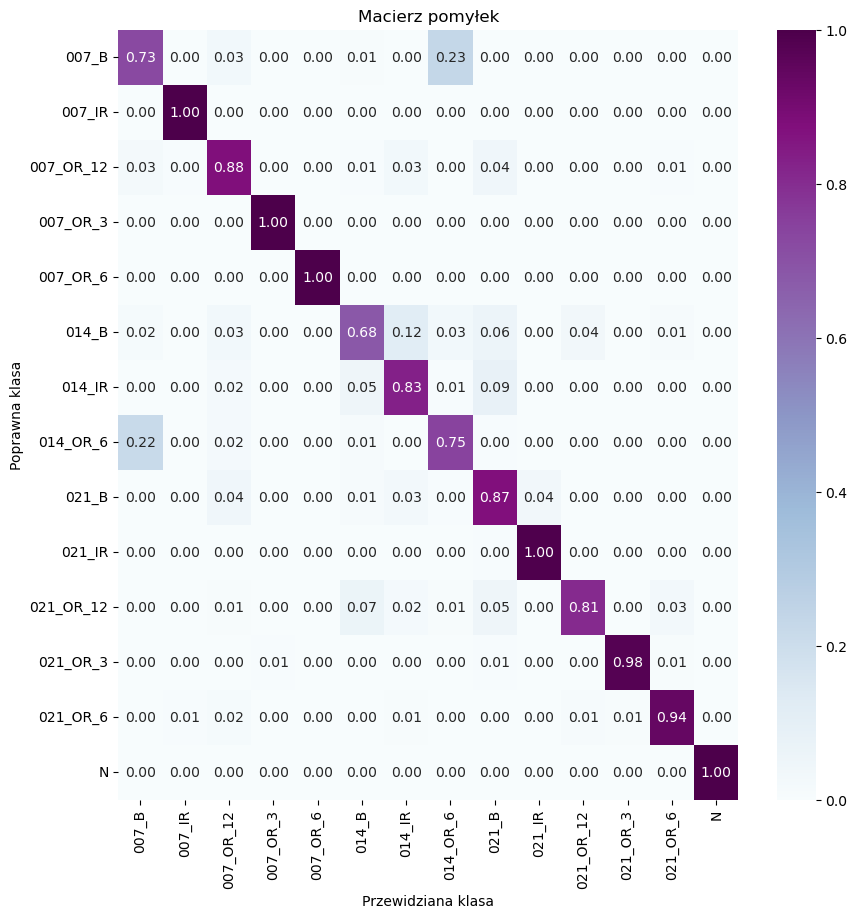

In [44]:
from sklearn.metrics import confusion_matrix

def inv_Transform_result(y_pred):    
    y_pred = y_pred.argmax(axis=1) # Przekształcanie predykcji z formatu one-hot na etykiety klas
    y_pred = encoder.inverse_transform(y_pred) # Inwersja kodowania etykiet na oryginalne wartości
    return y_pred

y_pred=cnn_model.predict(X_test) # Generowanie predykcji modelu

# Przekształcanie wyników predykcji i prawdziwych etykiet
Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)

# Tworzenie macierzy pomyłek
plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True ,xticklabels=encoder.classes_,yticklabels=encoder.classes_, cmap='BuPu', fmt='.2f')
plt.title('Macierz pomyłek')
plt.xlabel('Przewidziana klasa')
plt.ylabel('Poprawna klasa')

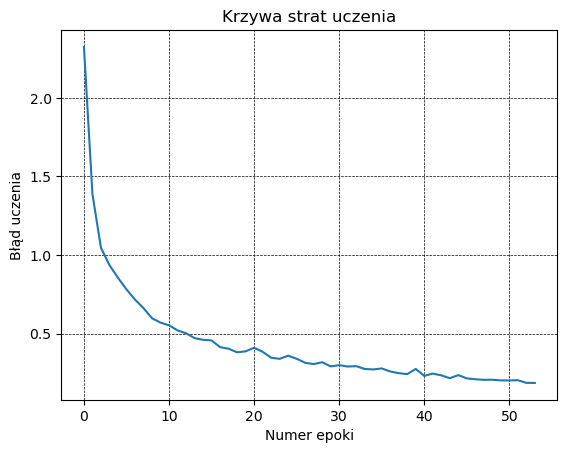

In [45]:
# Wyświetlanie krzywej strat uczenia
plt.title('Krzywa strat uczenia')
plt.xlabel('Numer epoki')
plt.ylabel("Błąd uczenia")
plt.plot(history.history['loss'])
plt.grid(color='k', linestyle='--', linewidth=0.5)

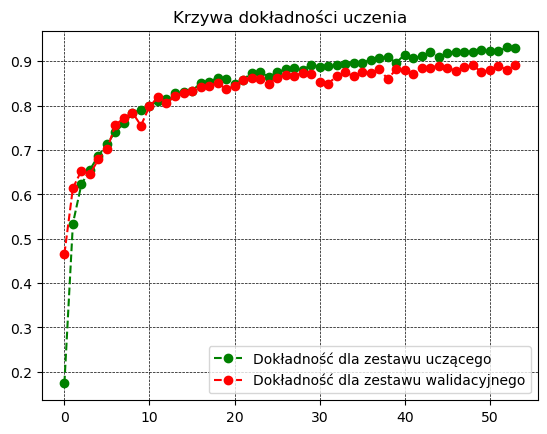

In [46]:
# Wyświetlanie krzywej dokładności uczenia
plt.title('Krzywa dokładności uczenia')
plt.plot(history.history['accuracy'],'go--')
plt.plot(history.history['val_accuracy'],'ro--')
plt.legend(['Dokładność dla zestawu uczącego','Dokładność dla zestawu walidacyjnego'])
plt.grid(color='k', linestyle='--', linewidth=0.5)
plt.show()

497/497 [==============================] - 5s 10ms/step
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 15880 samples in 0.000s...
[t-SNE] Computed neighbors for 15880 samples in 1.818s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15880
[t-SNE] Computed conditional probabilities for sample 2000 / 15880
[t-SNE] Computed conditional probabilities for sample 3000 / 15880
[t-SNE] Computed conditional probabilities for sample 4000 / 15880
[t-SNE] Computed conditional probabilities for sample 5000 / 15880
[t-SNE] Computed conditional probabilities for sample 6000 / 15880
[t-SNE] Computed conditional probabilities for sample 7000 / 15880
[t-SNE] Computed conditional probabilities for sample 8000 / 15880
[t-SNE] Computed conditional probabilities for sample 9000 / 15880
[t-SNE] Computed conditional probabilities for sample 10000 / 15880
[t-SNE] Computed conditional probabilities for sample 11000 / 15880
[t-SNE] Computed conditional probabilities for sample 12000 /

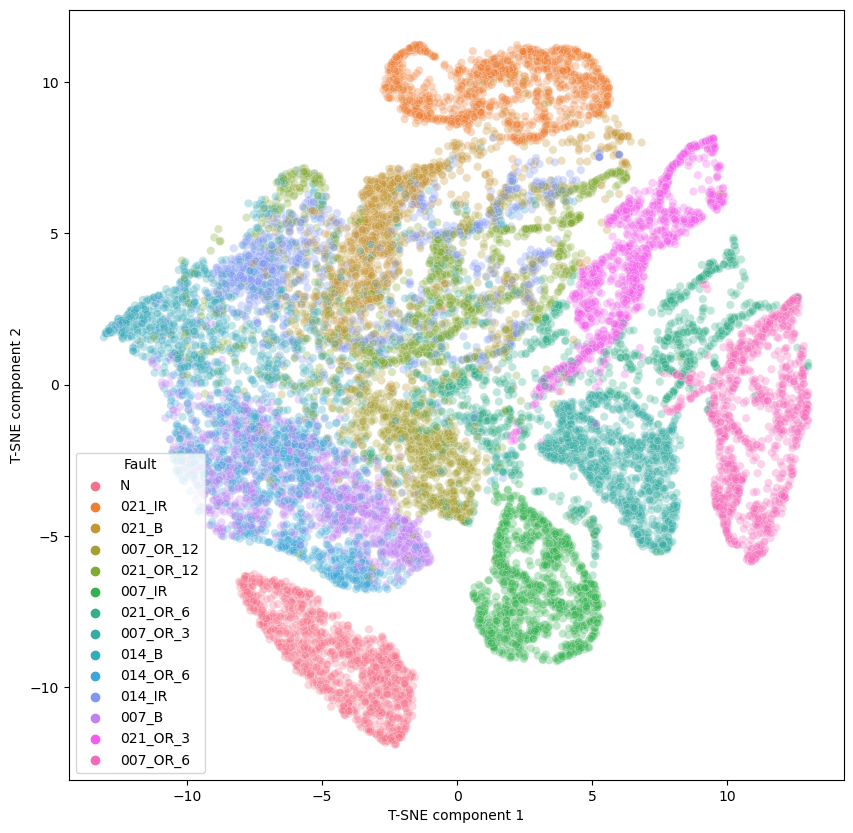

In [47]:
from sklearn.manifold import TSNE

# Tworzenie modelu pomocniczego, który zwraca wyjście z piątej warstwy oryginalnego modelu CNN
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[5].output)

# Przepuszczanie danych treningowych przez pomocniczy model, aby uzyskać wyniki z piątej warstwy
y_viz = dummy_cnn.predict(X_train)

# Użycie algorytmu t-SNE do redukcji wymiarowości danych wyjściowych do dwóch wymiarów
X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

# Tworzenie DataFrame z wynikami t-SNE, z kolumnami dla dwóch wymiarów t-SNE
tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

# Przekształcanie etykiet z formatu one-hot do oryginalnych etykiet i dodawanie ich do DataFrame
tSNEdf['Fault']=inv_Transform_result(y_train)


# Wizualizacja wyników t-SNE za pomocą wykresu punktowego
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

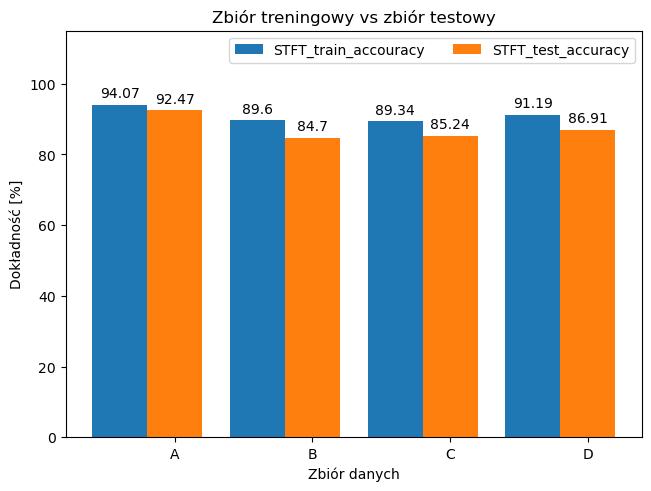

In [48]:
# Definiowanie danych
STFT_train_accouracy=[94.07, 89.60, 89.34, 91.19]
STFT_test_accuracy=[92.47, 84.70, 85.24, 86.91]

models = ('A', 'B', 'C', 'D') 
STFT_data = {
'STFT_train_accouracy' : (94.07, 89.60, 89.34, 91.19), 
'STFT_test_accuracy' : (92.47, 84.70, 85.24, 86.91),
}
# Przygotowanie danych do wykresu
x = np.arange(len(models))
width = 0.4
multiplier = 0

# Tworzenie wykresu
fig, ax = plt.subplots(layout = 'constrained')
for attribute, measurement in STFT_data.items():
    offset = width * multiplier
    rects= ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1
    
# Ustawienia osi i legendy       
ax.set_ylabel('Dokładność [%]')
ax.set_xlabel('Zbiór danych')
ax.set_title('Zbiór treningowy vs zbiór testowy')
ax.set_xticks(x + width, models)
ax.legend(loc='upper right', ncols=3)
ax.set_ylim(0, 115)
plt.show()